# Random Boosting Forest – Supervised Classification

This notebook demonstrates **supervised fraud detection** using the
`RandomBoostingForest` from `AILibs`.

**Key idea:** A sequence of shallow random decision trees is trained on
the *residuals* of the previous iteration (gradient-boosting style),
using random splits instead of optimal ones for speed and regularisation.

Because the fraud labels **are** available, we train the forest directly
on (features → label) and evaluate with standard binary-classification
metrics.

In [1]:
import numpy
import matplotlib.pyplot as plt
import AILibs

## 1 · Load the dataset

In [2]:
file_name = "/Users/michal/datasets/creditcard/creditcard.csv"
dataset   = AILibs.datasets.CSVDataset(file_name)

print("Dataset shape:", dataset.x.shape)
print("Total samples:", dataset.x.shape[0])

Dataset shape: (284807, 31)
Total samples: 284807


## 2 · Train / Test split

80 / 20 random split. The last column is the binary fraud label.

In [3]:
numpy.random.seed(42)

test_ratio = 0.2
indices    = numpy.arange(dataset.x.shape[0])
numpy.random.shuffle(indices)

split_idx     = int((1 - test_ratio) * dataset.x.shape[0])
train_indices = indices[:split_idx]
test_indices  = indices[split_idx:]

# Features (all columns except the last)
x_train = dataset.x[train_indices, :-1]
x_test  = dataset.x[test_indices,  :-1]

# Labels: binarise (> 0.5 → 1.0 = fraud)
y_train = (dataset.x[train_indices, -1] > 0.5) * 1.0
y_test  = (dataset.x[test_indices,  -1] > 0.5) * 1.0

print(f"Train : {x_train.shape},  fraud rate = {y_train.mean():.4f}")
print(f"Test  : {x_test.shape},  fraud rate = {y_test.mean():.4f}")

Train : (227845, 30),  fraud rate = 0.0017
Test  : (56962, 30),  fraud rate = 0.0018


## 3 · Class distribution

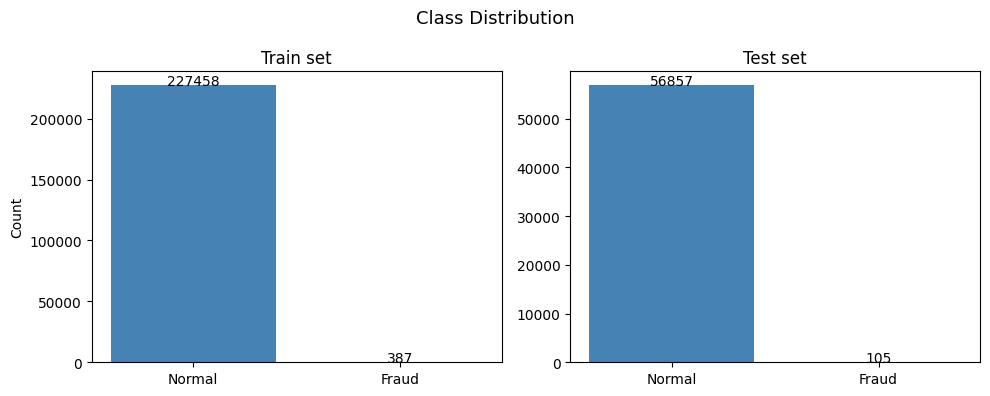

In [4]:
train_counts = [int((y_train == 0).sum()), int((y_train == 1).sum())]
test_counts  = [int((y_test  == 0).sum()), int((y_test  == 1).sum())]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].bar(["Normal", "Fraud"], train_counts, color=["steelblue", "tomato"])
axes[0].set_title("Train set")
axes[0].set_ylabel("Count")
for i, v in enumerate(train_counts):
    axes[0].text(i, v + 200, str(v), ha="center", fontsize=10)

axes[1].bar(["Normal", "Fraud"], test_counts, color=["steelblue", "tomato"])
axes[1].set_title("Test set")
for i, v in enumerate(test_counts):
    axes[1].text(i, v + 50, str(v), ha="center", fontsize=10)

plt.suptitle("Class Distribution", fontsize=13)
plt.tight_layout()
plt.show()

## 4 · Fit the Random Boosting Forest

The boosting forest trains each tree on the **residual** of the
previous ensemble, shrinking contributions by `learning_rate`.

| Parameter        | Value  | Description |
|------------------|-------:|-------------|
| `max_depth`      |     12 | Maximum tree depth |
| `num_trees`      |    128 | Number of boosting rounds |
| `num_subsamples` |   4096 | Subsample size per tree |
| `learning_rate`  |   0.25 | Shrinkage (default) |

In [5]:
forest = AILibs.forest.RandomBoostingForest()
forest.fit(x_train, y_train, max_depth=12, num_trees=128,
           num_subsamples=4096, learning_rate=0.25)

print("Random Boosting Forest fitted with", forest.num_trees, "trees")

Random Boosting Forest fitted with 128 trees


## 5 · Predict on the test set

In [6]:
y_pred = forest.predict_batch(x_test)

print(f"Prediction range : [{y_pred.min():.4f}, {y_pred.max():.4f}]")
print(f"Prediction mean  : {y_pred.mean():.4f}")

Prediction range : [-0.9563, 3.5099]
Prediction mean  : 0.0031


## 6 · Prediction distribution

We plot the raw predictions split by the true label. A good model
should push normal predictions toward 0 and fraud predictions toward 1.

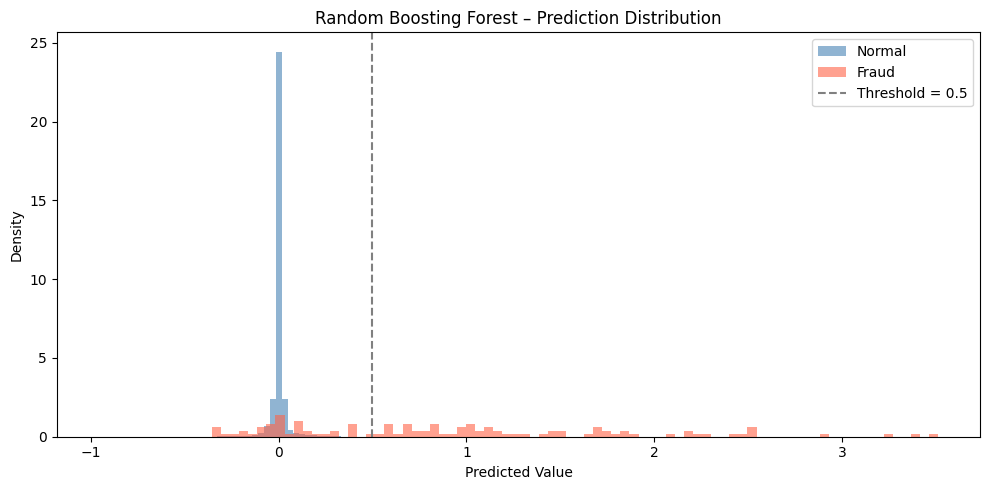

In [7]:
normal_mask  = y_test < 0.5
fraud_mask   = y_test >= 0.5

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(y_pred[normal_mask], bins=80, alpha=0.6, label="Normal",  color="steelblue", density=True)
ax.hist(y_pred[fraud_mask],  bins=80, alpha=0.6, label="Fraud",   color="tomato",    density=True)
ax.axvline(0.5, color="grey", linestyle="--", label="Threshold = 0.5")
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Density")
ax.set_title("Random Boosting Forest – Prediction Distribution")
ax.legend()
plt.tight_layout()
plt.show()

## 7 · Evaluate with detection metrics

Since this is supervised classification we use `detection_evaluation`
with a threshold of 0.5 (values > 0.5 are classified as fraud).

In [8]:
metrics = AILibs.metrics.detection_evaluation(y_test, y_pred, th=0.5)
print(AILibs.metrics.format_metrics(metrics))

n_samples: 56962
threshold: 0.5
accuracy: 0.99868
precision: 0.64706
recall: 0.62857
f1_score: 0.63768
mcc: 0.63709
specificity: 0.99937
balanced_accuracy: 0.81397
iou: 0.46809
dice: 0.63768
tp: 66
tn: 56821
fp: 36
fn: 39


## 8 · Confusion matrix heatmap

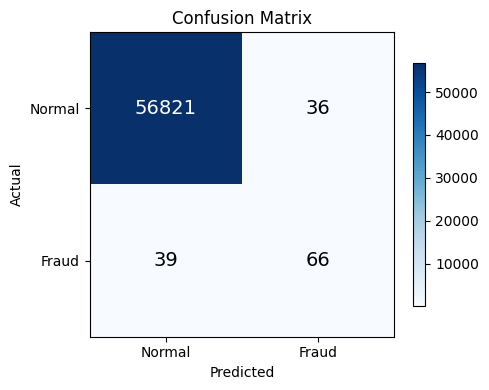

In [9]:
cm = numpy.array([[metrics["tn"], metrics["fp"]],
                  [metrics["fn"], metrics["tp"]]])

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm, cmap="Blues")

for i in range(2):
    for j in range(2):
        ax.text(j, i, str(cm[i, j]), ha="center", va="center",
                fontsize=14, color="white" if cm[i, j] > cm.max() / 2 else "black")

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Normal", "Fraud"])
ax.set_yticklabels(["Normal", "Fraud"])
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix")
fig.colorbar(im, ax=ax, shrink=0.8)
plt.tight_layout()
plt.show()

## 9 · Key metrics bar chart

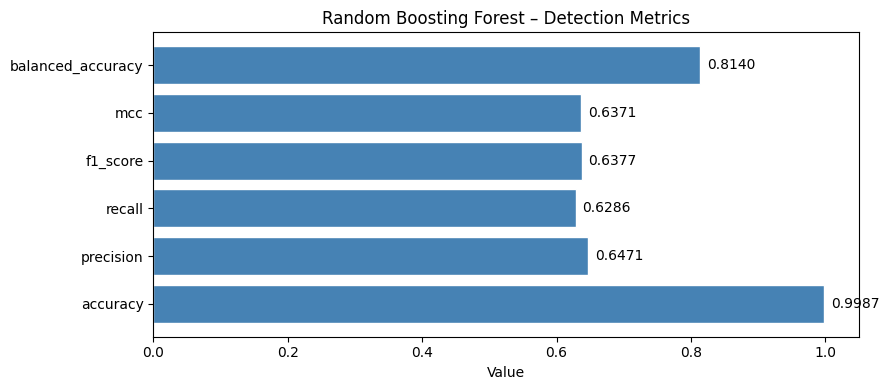

In [10]:
metric_names  = ["accuracy", "precision", "recall", "f1_score", "mcc", "balanced_accuracy"]
metric_values = [metrics[m] for m in metric_names]

fig, ax = plt.subplots(figsize=(9, 4))
bars = ax.barh(metric_names, metric_values, color="steelblue", edgecolor="white")
ax.set_xlim(0, 1.05)
ax.set_xlabel("Value")
ax.set_title("Random Boosting Forest – Detection Metrics")

for bar, val in zip(bars, metric_values):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
            f"{val:.4f}", va="center", fontsize=10)

plt.tight_layout()
plt.show()

## 10 · Compare with plain Random Forest

For reference, we also train a non-boosted `RandomForest` and compare.

In [11]:
rf = AILibs.forest.RandomForest()
rf.fit(x_train, y_train, max_depth=12, num_trees=128, num_subsamples=4096)

y_pred_rf  = rf.predict_batch(x_test)
metrics_rf = AILibs.metrics.detection_evaluation(y_test, y_pred_rf, th=0.5)

print("=== Random Forest (no boosting) ===")
print(AILibs.metrics.format_metrics(metrics_rf))

=== Random Forest (no boosting) ===
n_samples: 56962
threshold: 0.5
accuracy: 0.99849
precision: 0.80645
recall: 0.2381
f1_score: 0.36765
mcc: 0.43771
specificity: 0.99989
balanced_accuracy: 0.61899
iou: 0.22523
dice: 0.36765
tp: 25
tn: 56851
fp: 6
fn: 80


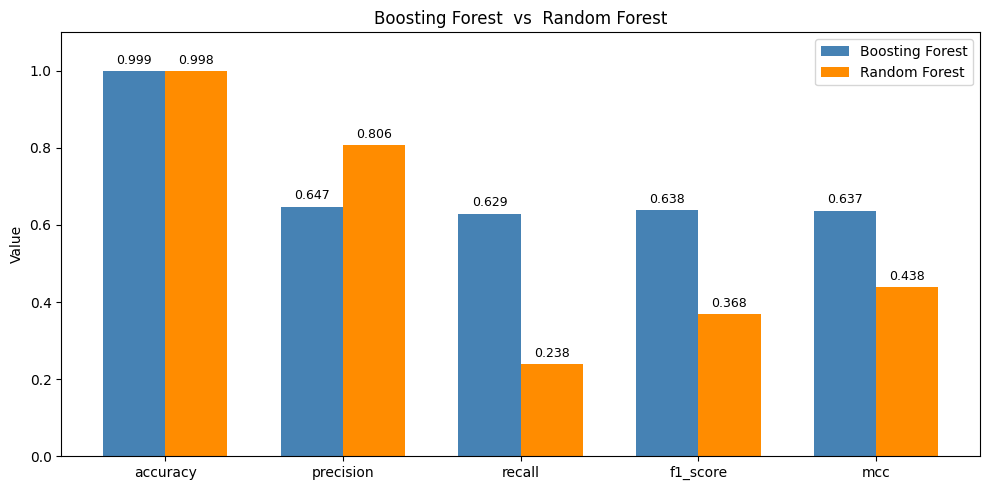

In [12]:
# Side-by-side comparison
compare_metrics = ["accuracy", "precision", "recall", "f1_score", "mcc"]

boost_vals = [metrics[m]    for m in compare_metrics]
rf_vals    = [metrics_rf[m] for m in compare_metrics]

x_pos = numpy.arange(len(compare_metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x_pos - width / 2, boost_vals, width, label="Boosting Forest", color="steelblue")
ax.bar(x_pos + width / 2, rf_vals,    width, label="Random Forest",   color="darkorange")

ax.set_xticks(x_pos)
ax.set_xticklabels(compare_metrics)
ax.set_ylim(0, 1.1)
ax.set_ylabel("Value")
ax.set_title("Boosting Forest  vs  Random Forest")
ax.legend()

# Value labels
for i, (bv, rv) in enumerate(zip(boost_vals, rf_vals)):
    ax.text(i - width / 2, bv + 0.02, f"{bv:.3f}", ha="center", fontsize=9)
    ax.text(i + width / 2, rv + 0.02, f"{rv:.3f}", ha="center", fontsize=9)

plt.tight_layout()
plt.show()